In [1]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
import  matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.sans-serif'] = ['SimHei'] # 指定默认字体
plt.rcParams['axes.unicode_minus'] = False # 解决保存图像时负号‘-’显示为方块的问题

In [6]:
data = pd.read_csv('../task3/data_model.csv')

In [57]:
data.loc[data['DAYS_EMPLOYED']==365243,'DAYS_EMPLOYED'] = np.nan
data['AGE'] = round(-data.DAYS_BIRTH/365,0)
data['WORK_TIME'] = round(-data.DAYS_EMPLOYED/365,0)

In [58]:
data.head(2)

,Unnamed: 0,ID,is_ovd,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,...,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,AGE,WROKING_TIME,WORK_TIME
0,0,5008806,0.0,M,Y,Y,0,112500.0,Working,Secondary / secondary special,...,-1134.0,1,0,0,0,Security staff,2.0,59.0,3.0,3.0
1,1,5008809,0.0,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,...,-3051.0,1,0,1,1,Sales staff,1.0,52.0,8.0,8.0


#### 分类变量WOE、IV

In [ ]:
data.fillna('Unknow',inplace=True)

In [97]:
def clas_woe_iv(data = data):
    dic = {'CODE_GENDER':'性别','FLAG_OWN_CAR':'是否有车','FLAG_OWN_REALTY':'是否有房产','NAME_INCOME_TYPE':'收入类型','NAME_EDUCATION_TYPE':'教育程度','NAME_FAMILY_STATUS':'婚姻状态',
           'NAME_HOUSING_TYPE':'居住方式','FLAG_MOBIL':'是否有手机','FLAG_WORK_PHONE':'是否有工作电话','FLAG_PHONE':'是否有电话','FLAG_EMAIL':'是否有邮件','OCCUPATION_TYPE':'职业'}
    name_dic = {'F':'女','M':'男','Y':'是','N':'否','1':'是','0':'否'}
    
    writer = pd.ExcelWriter('分类变量分箱2.xlsx'); row = 0
    for key in dic:
        df = pd.DataFrame(columns = ['客户属性','客户数','坏客户数','好客户数','坏客户占比','好客户占比','组占比','woe','iv'])
        df['客户属性'] = data[key].value_counts().index 
        df['客户数'] = df['客户属性'].apply(lambda x: data[data[key]==x]['is_ovd'].count())
        df['坏客户数'] = df['客户属性'].apply(lambda x: data[data[key]==x][data['is_ovd']==1].count())
        df['好客户数'] = df['客户数'] - df['坏客户数']
        
        df['组占比'] = df['客户数'].apply(lambda x: round(x/sum(df['客户数']),4))

        df['客户属性'] = data[key].value_counts().rename(index=name_dic).index
        df.set_index('客户属性',inplace=True)

        if (df['组占比']<0.05).agg(sum) > 1 :                  # 合并组占比 < 5%  
            df.loc['其他'] = df[df['组占比']<0.05].agg(sum) 
            a = df[df['组占比']<0.05].index.values
            df.drop(a[~np.isin(a,'其他')],axis=0,inplace=True) # df['其他']被误删了
        
        df['坏客户占比'] = df['坏客户数'].apply(lambda x: x/sum(df['坏客户数']))
        df['好客户占比'] = df['好客户数'].apply(lambda x: x/sum(df['好客户数']))
        df['woe'] = np.log(df['坏客户占比']/df['好客户占比']).apply(lambda x: round(x,4))         # woe
        df['iv'] = ((df['坏客户占比'] - df['好客户占比'])*df['woe']).apply(lambda x: round(x,4))  # iv

        df = df.sort_values(by='woe',ascending=False) # 排序
        df.loc['合计'] = df.agg(sum) # 合计
        df.reset_index(inplace=True)
        df.insert(0,'变量',dic[key])
        df['组占比'] = df['组占比'].apply(lambda x: format(x,'.2%'))
        
        df.to_excel(writer,startrow=row,index=False)
        row = row + len(df) + 2
    writer.save()

In [98]:
clas_woe_iv()

D:\software\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
D:\software\Anaconda3\lib\site-packages\pandas\core\series.py:853: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


#### 获得最优分箱边界值函数的实现

In [38]:
def optimal_binning_boundary(x: pd.Series, y: pd.Series,leaf=6, nan: float = -999.) -> list:
    '''
        利用决策树获得最优分箱的边界值列表
        leaf: 最大叶子节点数
    '''
    boundary = []  # 待return的分箱边界值列表
    
    x = x.fillna(nan).values  # 填充缺失值
    y = y.values
    
    clf = DecisionTreeClassifier(criterion='entropy',    #“信息熵”最小化准则划分
                                 max_leaf_nodes=leaf,       # 最大叶子节点数
                                 min_samples_leaf=0.05)  # 叶子节点样本数量最小占比

    clf.fit(x.reshape(-1, 1), y)  # 训练决策树
    
    n_nodes = clf.tree_.node_count
    children_left = clf.tree_.children_left
    children_right = clf.tree_.children_right
    threshold = clf.tree_.threshold
    
    for i in range(n_nodes):
        if children_left[i] != children_right[i]:  # 获得决策树节点上的划分边界值
            boundary.append(threshold[i])

    boundary.sort()

    min_x = x.min()
    max_x = x.max() + 0.1  # +0.1是为了考虑后续groupby操作时，能包含特征最大值的样本
    boundary = [min_x] + boundary + [max_x]

    return boundary

#### 获得某个变量各个分箱的WOE、IV值函数的实现

In [62]:
def feature_woe_iv(x: pd.Series, y: pd.Series,leaf=6, nan: float = -999.) -> pd.DataFrame:
    '''
        计算变量各个分箱的WOE、IV值，返回一个DataFrame
        leaf: 最大叶子节点数
    '''
    x = x.fillna(nan)
    boundary = optimal_binning_boundary(x, y, leaf,nan)        # 获得最优分箱边界值列表
    df = pd.concat([x, y], axis=1)                        # 合并x、y为一个DataFrame，方便后续计算
    df.columns = ['x', 'y']                               # 特征变量、目标变量字段的重命名
    df['bins'] = pd.cut(x=x, bins=boundary, right=False)  # 获得每个x值所在的分箱区间
    
    grouped = df.groupby('bins')['y']                     # 统计各分箱区间的好、坏、总客户数量
    result_df = grouped.agg([('总客户数', 'count'),
                             ('坏客户数',   lambda y: (y == 1).sum()),
                             ('好客户数',  lambda y: (y == 0).sum())])

    result_df['好客户占比'] = result_df['好客户数'] / result_df['好客户数'].sum()       # 好客户占比
    result_df['坏客户占比'] = result_df['坏客户数'] / result_df['坏客户数'].sum()          # 坏客户占比
    result_df['组占比'] = result_df['总客户数'] / result_df['总客户数'].sum()    # 总客户占比

    result_df['坏客户率'] = (result_df['坏客户数'] / result_df['总客户数']).apply(lambda x: format(x,'.2%'))             # 坏比率
    
    result_df['woe'] = np.log( result_df['坏客户占比']/result_df['好客户占比'])              # WOE
    result_df['iv'] = ( result_df['坏客户占比'] - result_df['好客户占比']) * result_df['woe']  # IV
    
    print(f"该变量IV = {result_df['iv'].sum()}")
    
    return result_df

##### 年收入

该变量IV = 0.014867061939934983


,总客户数,坏客户数,好客户数,好客户占比,坏客户占比,组占比,坏客户率,woe,iv
bins,,,,,,,,,
"[26100.0, 108225.0)",36393,716.0,35677.0,0.146554,0.176398,0.147044,1.97%,0.185348,0.005532
"[108225.0, 225382.5)",156746,2621.0,154125.0,0.633115,0.645726,0.633322,1.67%,0.019722,0.000249
"[225382.5, 6750000.1)",54359,722.0,53637.0,0.220330,0.177876,0.219634,1.33%,-0.214040,0.009087


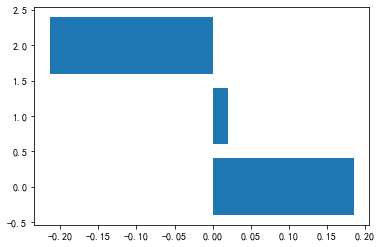

In [84]:
df = feature_woe_iv(data['AMT_INCOME_TOTAL'],data['is_ovd'],leaf=3) # leaf: 最大叶子节点数
plt.barh(range(len(df)),df['woe'])
df

##### 年龄

该变量IV = 0.009902890427869902


,总客户数,坏客户数,好客户数,好客户占比,坏客户占比,组占比,坏客户率,woe,iv
bins,,,,,,,,,
"[21.0, 35.5)",65511,1146.0,64365.0,0.264399,0.282336,0.264693,1.75%,0.065637,0.001177
"[35.5, 43.5)",59836,817.0,59019.0,0.242439,0.201281,0.241764,1.37%,-0.186046,0.007657
"[43.5, 69.1)",122151,2096.0,120055.0,0.493163,0.516383,0.493543,1.72%,0.046011,0.001068


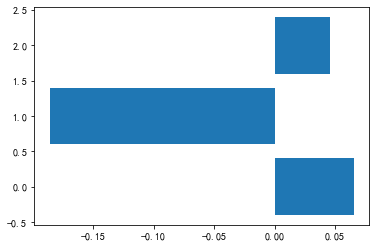

In [82]:
df = feature_woe_iv(data['AGE'],data['is_ovd'],leaf=3) # leaf: 最大叶子节点数
plt.barh(range(len(df)),df['woe'])
df

##### 工作年限

该变量IV = 0.01123839809206707


,总客户数,坏客户数,好客户数,好客户占比,坏客户占比,组占比,坏客户率,woe,iv
bins,,,,,,,,,
"[-999.0, -499.5)",42232,691.0,41541.0,0.170642,0.170239,0.170636,1.64%,-0.002367,9.545920e-07
"[-499.5, 7.5)",126300,2257.0,124043.0,0.509544,0.556048,0.510307,1.79%,0.087338,4.061548e-03
"[7.5, 48.1)",78966,1111.0,77855.0,0.319813,0.273713,0.319057,1.41%,-0.155658,7.175895e-03


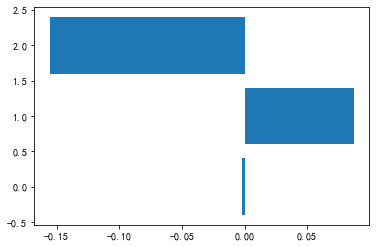

In [81]:
df = feature_woe_iv(data['WORK_TIME'],data['is_ovd'],leaf=3) # leaf: 最大叶子节点数
plt.barh(range(len(df)),df['woe'])
df

##### 孩子个数

该变量IV = 0.0017228642125102023


,总客户数,坏客户数,好客户数,好客户占比,坏客户占比,组占比,坏客户率,woe,iv
bins,,,,,,,,,
"[0.0, 0.5)",171557,2888.0,168669.0,0.692859,0.711505,0.693165,1.68%,0.026556,0.000495
"[0.5, 1.5)",49822,776.0,49046.0,0.201471,0.191180,0.201303,1.56%,-0.052432,0.000540
"[1.5, 14.1)",26119,395.0,25724.0,0.105669,0.097315,0.105532,1.51%,-0.082364,0.000688


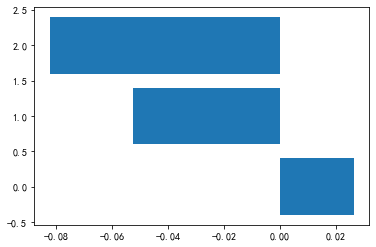

In [79]:
df = feature_woe_iv(data['CNT_CHILDREN'],data['is_ovd'],leaf=5) # leaf: 最大叶子节点数
plt.barh(range(len(df)),df['woe'])
df

##### 家庭人数

该变量IV = 0.0037391648439557158


,总客户数,坏客户数,好客户数,好客户占比,坏客户占比,组占比,坏客户率,woe,iv
bins,,,,,,,,,
"[1.0, 1.5)",46505,818.0,45687.0,0.187673,0.201527,0.187901,1.76%,0.071223,0.000987
"[1.5, 2.5)",132875,2226.0,130649.0,0.536681,0.548411,0.536873,1.68%,0.021622,0.000254
"[2.5, 3.5)",43528,651.0,42877.0,0.176130,0.160384,0.175872,1.50%,-0.093651,0.001475
"[3.5, 15.1)",24590,364.0,24226.0,0.099516,0.089677,0.099354,1.48%,-0.104098,0.001024


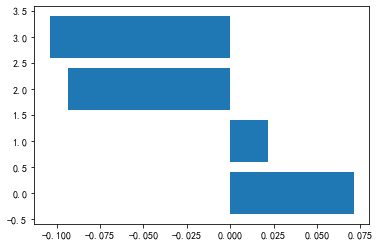

In [78]:
df = feature_woe_iv(data['CNT_FAM_MEMBERS'],data['is_ovd'],leaf=5) # leaf: 最大叶子节点数
plt.barh(range(len(df)),df['woe'])
df